# Auto process images for training with YOLOv7

The following notebook uses YOLOv7 to perform object detection on a folder of images. The detected objects are then cropped to their bounding boxes and saved to a new folder. Any images that are not detected are saved for manual processing.

The purpose of this notebook is to use the object detection capabilities of YOLOv7 to detect dog faces in the images, which will then be used to train a recognition model.

it runs the detect.py script from yolov7 folder using the best weights i trained.



In [1]:
#imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#run detect on images in folder
folder_path = "C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\researchproject\\FaceRecognition\\data\\Images\\"
conf = 0.4
weights = "runs/train/yolov7-custom23/weights/best.pt"

%cd yolov7
!python detect.py --weights {weights} --img-size 256 --conf {conf} --save-txt --source {folderPath}

c:\Users\viers\OneDrive\Bureaublad\ResearchProject\researchproject\FaceDetection-Yolo\yolov7
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=256, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\researchproject\\FaceRecognition\\data\\Images\\', update=False, view_img=False, weights=['runs/train/yolov7-custom23/weights/best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 face, Done. (115.2ms) Inference, (37.7ms) NMS
 The image with the result is saved in: runs\detect\exp18\1.jpg
Done. (114.0ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp18\10.jpg
1 face, Done. (114.0ms) Inference, (2.0ms) NMS
 The image with the result is sa

YOLOR  13d11816 torch 1.7.0+cu101 CUDA:0 (GeForce GTX 1650 with Max-Q Design, 4096.0MB)

Model Summary: 306 layers, 36479926 parameters, 6194944 gradients, 103.2 GFLOPS


In [4]:
#yolov7 detect will output a folder called exp, the detect will append a number to the exp folder name every time it runs following code will find the latest version of the exp folder.
detect_path = "C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\researchproject\\FaceDetection-Yolo\\yolov7\\runs\\detect\\"
exp_folders = os.listdir(detect_path)

exp_folders_versions = []
for exp in exp_folders:
    exp = exp.split("exp")[1]
    if exp == "":
        exp = 0
    exp_folders_versions.append(int(exp))

latest_version = max(exp_folders_versions)
latest_version_path = detect_path + "exp" + str(latest_version) + "\\"
print(latest_version_path)

C:\Users\viers\OneDrive\Bureaublad\ResearchProject\researchproject\FaceDetection-Yolo\yolov7\runs\detect\exp18\


In [5]:
images = []
coords = []
detected_image_names = []
undetected_images = []
cropped_face_path = "C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\researchproject\\FaceDetection-Yolo\\data\\autoprocess\\croppedFaces\\"
undetected_images_path = "C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\researchproject\\FaceDetection-Yolo\\data\\autoprocess\\undetectedFaces\\"

#creates paths if they dont exist
if not os.path.exists(cropped_face_path):
    os.makedirs(cropped_face_path)
if not os.path.exists(undetected_images_path):
    os.makedirs(undetected_images_path)

#reads labels from latest version of exp folder
labels_path = latest_version_path + "labels\\"
for label in os.listdir(labels_path):
    with open(labels_path + label, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        break
    for line in lines:
        line = line.split(" ")
        #checks if class is 0 
        if line[0] == "0":
            #saves image name and coords of bounding box
            detected_image_names.append(label.split(".txt")[0] + ".jpg")
            images.append(latest_version_path+label.split(".txt")[0] + ".jpg")
            coords.append(line[1:])

print(images[0], coords[0])

#locate undetected images to manually process
for img in os.listdir(folder_path):
    if img not in detected_image_names:
        undetected_images.append(img)

print(f"length of detected images: {len(detected_image_names)}")
print(f"length of undetected images: {len(undetected_images)}")

print(undetected_images[:5])
print(detected_image_names[:5])

#saves undetected images to folder for manual processing
for i in range(len(undetected_images)):
    cv2.imwrite(undetected_images_path + undetected_images[i], cv2.imread(folder_path + "\\" + undetected_images[i]))




C:\Users\viers\OneDrive\Bureaublad\ResearchProject\researchproject\FaceDetection-Yolo\yolov7\runs\detect\exp18\1.jpg ['0.51216', '0.42072', '0.343385', '0.244163\n']
length of detected images: 221
length of undetected images: 23
['10.jpg', '105.jpg', '128.jpg', '131.jpg', '144.jpg']
['1.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg']


In [6]:
#draw boxes on images

img_size = 512
faces = []

#yolov7 outputs bounding box coords in xywh format
#following function converts to x1y1x2y2 format
def convertYoloCoordsToBounding(coords,imgSize):
    x = float(coords[0])
    y = float(coords[1])
    w = float(coords[2])
    h = float(coords[3])
    x1 = int((x-w/2)*imgSize)
    y1 = int((y-h/2)*imgSize)
    x2 = int((x+w/2)*imgSize)
    y2 = int((y+h/2)*imgSize)
    return [x1, y1, x2, y2]

def cropFace(img, coords):
    x1, y1, x2, y2 = coords
    return img[y1:y2, x1:x2]


#crops faces from images and saves them to folder
for i in range(len(images)):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (img_size, img_size)) 
    img = cropFace(img, convertYoloCoordsToBounding(coords[i], img_size))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    cv2.imwrite(cropped_face_path + detected_image_names[i], img)
    faces.append(img)




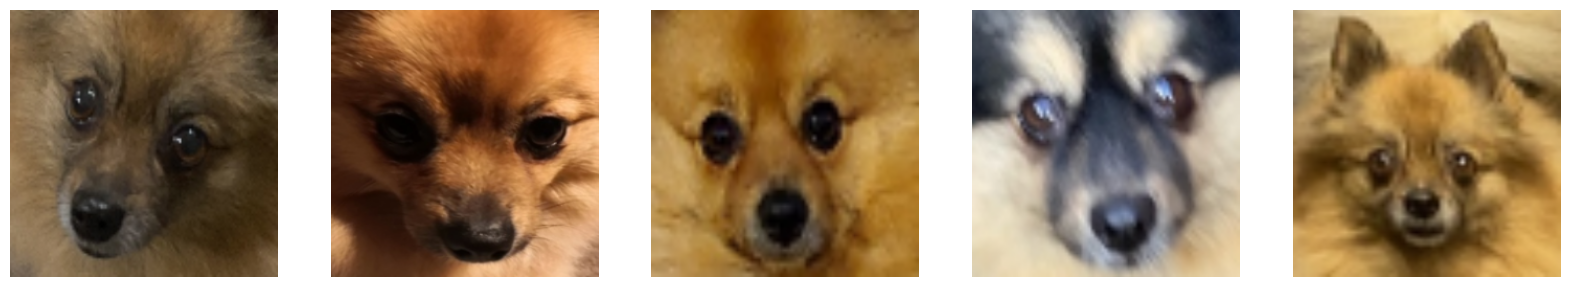

In [10]:
#dsiplay random faces
fig, axs = plt.subplots(1,5, figsize=(20, 20))
for i in range(5):
    x = random.randint(0, len(faces))
    img = cv2.cvtColor(faces[x], cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()


In [11]:
print(f"images to manually process: {undetected_images}")

images to manually process: ['10.jpg', '105.jpg', '128.jpg', '131.jpg', '144.jpg', '154.jpg', '155.jpg', '159.jpg', '160.jpg', '163.jpg', '164.jpg', '189.jpg', '197.jpg', '207.jpg', '208.jpg', '21.jpg', '25.jpg', '27.jpg', '40.jpg', '5.jpg', '50.jpg', '85.jpg', '9.jpg']
